In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import LabelEncoder
lbl=LabelEncoder()

In [4]:
test=pd.read_csv(r'/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
train=pd.read_csv(r'/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

In [5]:
train=train.set_index('Id')
test=test.set_index('Id')

In [6]:
train.Alley=train.Alley.fillna('Grvl')

In [7]:
nan_col=[i for i in train.columns if train[i].isna().any()]
nan_col

['LotFrontage',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [8]:
for i in nan_col:
    if train[i].dtype in ['int64','float64']:
        train[i]=train[i].fillna(train[i].mean())
    

In [9]:
train['Electrical']=train['Electrical'].fillna(train['Electrical'].value_counts().index[0])

In [10]:
for i in nan_col:
    train[i]=train[i].fillna(train[i].value_counts().index[0])

In [11]:
train['house_age']=train['YrSold']-train['YearBuilt']
test['house_age']=test['YrSold']-test['YearBuilt']


In [12]:
test_nan_col=[i for i in test.columns if test[i].isna().any()]
test_nan_col

['MSZoning',
 'LotFrontage',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType']

In [13]:
for i in test_nan_col:
    if test[i].dtype in ['int64','float64']:
        test[i]=test[i].fillna(test[i].mean())
    

In [14]:
for i in test_nan_col:
    test[i]=test[i].fillna(test[i].value_counts().index[0])

In [15]:
for i in train.select_dtypes('O').columns:
    train[i]=lbl.fit_transform(train[i])

In [16]:
for i in test.select_dtypes('O').columns:
    test[i]=lbl.fit_transform(test[i])

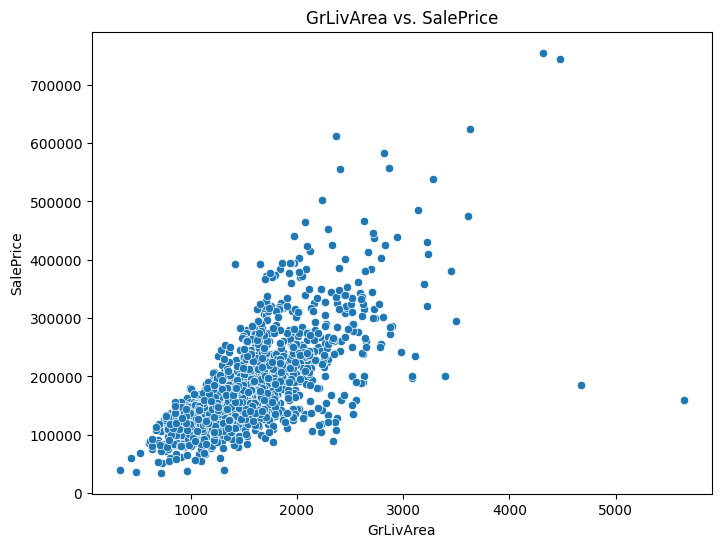

In [17]:
# Scatter plot: GrLivArea vs. SalePrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train)
plt.title('GrLivArea vs. SalePrice')
plt.show()

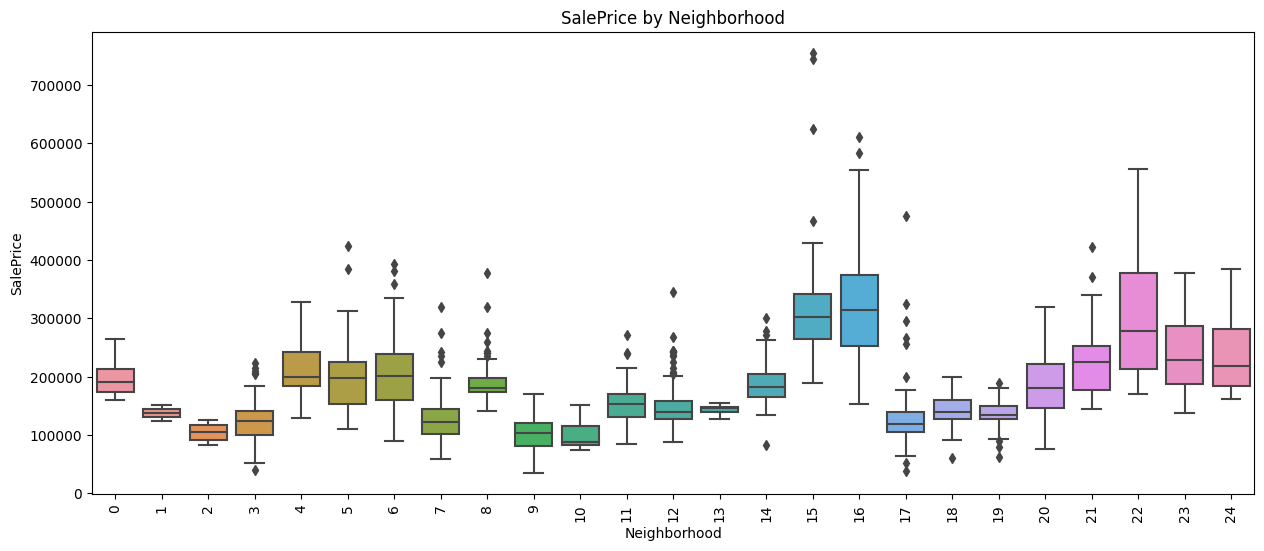

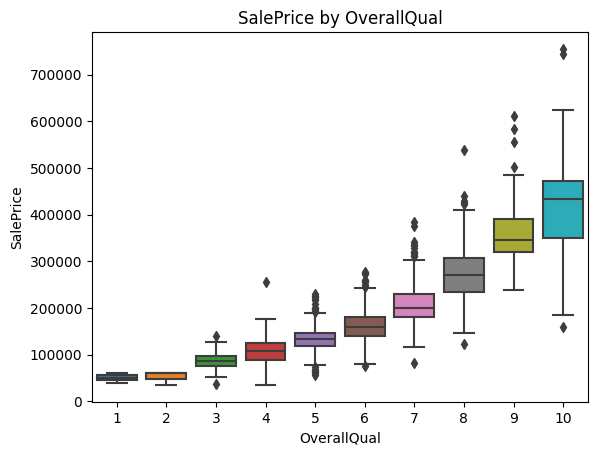

In [18]:
# Example: SalePrice vs. Neighborhood
plt.figure(figsize=(15, 6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=train)
plt.xticks(rotation=90)
plt.title('SalePrice by Neighborhood')
plt.show()

# Example: OverallQual (ordinal)
sns.boxplot(x='OverallQual', y='SalePrice', data=train)
plt.title('SalePrice by OverallQual')
plt.show()

In [19]:
x=train.drop(columns='SalePrice')
y=train.SalePrice

In [20]:
#modeling 

#!pip install xgboost
from sklearn.metrics import mean_squared_error
from xgboost import  XGBRegressor

In [21]:
xgr=XGBRegressor()

In [22]:
xgr.fit(x,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
xgr.predict(test)

array([124090.71 , 154032.22 , 186887.27 , ..., 161496.48 , 119241.234,
       199308.44 ], dtype=float32)

In [24]:
mean_squared_error(y,xgr.predict(x))

2206081.594628384

In [25]:
test['SalePrice']=xgr.predict(test)


In [26]:
submit=test.SalePrice

In [26]:
#submit.to_csv(r'submission.csv')

In [ ]:
#FInding the best paramters using hyperparameter tuning

param_dist = {
    'n_estimators': [50,,90, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}


In [28]:
from sklearn.model_selection import RandomizedSearchCV


rand=RandomizedSearchCV(xgr, param_dist,cv=6,n_jobs=-1,scoring='neg_mean_squared_error',verbose=2,n_iter=50)

In [ ]:
rand.fit(x,y)

Fitting 6 folds for each of 50 candidates, totalling 300 fits


In [ ]:
rand.best_params_

In [27]:
#Applyig best paramaters of random seach cv

model = XGBRegressor(
    n_estimators=130,
    learning_rate=0.09,
    max_depth=5,
    subsample=1,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=3,
    reg_alpha=0.1,
    reg_lambda=0.1,
    objective='reg:squarederror',
    eval_metric='rmse',
    seed=42,
    n_jobs=-1
)

In [28]:
model.fit(x,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.09, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=130, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [29]:
mean_squared_error(y,model.predict(x))

52466143.61688324

In [30]:
submit2=pd.DataFrame()
pred2=model.predict(test.drop(columns='SalePrice'))

In [31]:
id=test.index

In [32]:
submit2=pd.DataFrame({'Id':id,'SalePrice':pred2})

In [33]:
submit2.set_index('Id',inplace=True)

In [34]:
submit2.to_csv('submission_2.csv')